# Visualization of $\mathbf{X_c}$ 's  missing attractiveness as a vector


Here is the paragraph from the paper:


## 3.2 Direction and rate of C storage change at a given time


In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display_pretty,display
from sympy import var,Function,sin,cos,diag,simplify,lambdify,Piecewise,pi
from ComputabilityGraphs.CMTVS import CMTVS
from bgc_md2.helper import bgc_md2_computers
from bgc_md2.display_helpers import mass_balance_equation
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)
from bgc_md2.display_helpers import mass_balance_equation
import numpy as np
from scipy.integrate import solve_ivp
import CompartmentalSystems.helpers_reservoir as hr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [91]:
def plot_vectors(mvs,par_dict,X_0,times):
    # create the numerical system from the symbolic one
    # this part uses the symbolic framework I developed together with Holger
    # Althouhg in this case we could have written the matrices by hand...
    state_vector=mvs.get_StateVariableTuple()

    B_func = hr.numerical_array_func(
            state_vector = state_vector,
            time_symbol=t,
            expr=mvs.get_CompartmentalMatrix(),
            parameter_dict=par_dict,
            func_dict=func_dict
    )
    u_func = hr.numerical_array_func(
            state_vector = state_vector,
            time_symbol=t,
            expr=mvs.get_InputTuple(),
            parameter_dict=par_dict,
            func_dict=func_dict
    )
    n=len(mvs.get_StateVariableTuple())
    
    # uncomment to test that we got the function right
    B_0=B_func(0,X_0) # in our linear case B does not realy depend on X
    print(B_0)
    #I_0=u_func(0,X_0) # in our linear case u does not realy depend on X
    #np.linalg.inv(B_0)
    
    def X_dot(t, X): 
        B=B_func(t,X)
        # code for checking Yiqi's claim that the inverse of the (negative) Compartmental
        # matrix has only positive entries is true in this instance
        if not(
            all(
                [
                    np.sign(np.linalg.inv(-B)[i,j])>0 for i in range(2) for j in range(2)
                ]
            )
        ):
            print('non positive inverse')
        return u_func(t,X).reshape(n)+B @ X
    
    # uncomment to check our right hand side
    # X_dot(0,X_0)
    # Here you could also just write your own rhs in python without having to use
    # the symbolic translation and the packages that provide it.
    
    # actually solve the system
    sol = solve_ivp(
        X_dot, 
        t_span=[t_eval.min(),t_eval.max()],
        t_eval=t_eval,
        y0=X_0,
        method="Radau" # use an implicit solver for safety (overkill ...)
    )
    
    ss=100
    Xs=sol.y.transpose()
    times=sol.t
    
    # compute some diagnostic variables as arrays (time indexed)
    nt=len(times)
    rnt=range(nt)
    
    # the derivative vectors
    X_dots=np.array([X_dot(times[i],Xs[i,:]) for i in rnt]) 
   
    Bs=np.array([B_func(times[i],Xs[i]) for i in rnt])
    # in Yiqis nomenclature the system is written 
    # as d/dt X=I(t)-B(t)X 
    # whereas others (like me) would write
    # it as d/dt X = I(t) +B(t) X... hence with my B_func Tau=(-B)^-1
    Taus=np.array(list(map(np.linalg.inv,-Bs)))
    
    # input vectors
    Is=np.array(
        [
            # more general u_func for nonlinear pool dependent input (Xs)
            # which in the linear case are just ignored
            u_func(times[i],Xs[i]) 
            for i in rnt
        ]
    )
    
    X_cs = np.array(
        [
            Taus[i]@Is[i].reshape(n)
            for i in rnt
        ]
    )
    
    # in the paper the Carbon Storage Potential X_p 
    # which in the case of a one pool system has the same sign as the
    # derivative \dot{X}  which is the argument on which calling X_c an attractor 
    # for X rests.
    # The plots will show that this property does not persist in higher dimensions
    X_ps=X_cs-Xs
    
    
    # plot the time dependent matrix elements of the right hand side:
    # external influxes I and internal flux rates
    
    f=plt.figure(figsize=(20,20))
    #trajectory for X
    infbs=mvs.get_InputTuple()
    #for i,expr in enumerate((r_leaf2out,r_leaf2wood, I_leaf)):
    #ax=f.add_subplot(3,1,i+1)
    ax=f.add_subplot(2,1,1)
    ax.set_title("Inputs")
    for i in range(2):
        ax.plot(
            times,
            Is[:,i],
            label=str(state_vector[i])
        )
    ax.legend()
    
    ax=f.add_subplot(2,1,2)
    ax.set_title("Matrix elements")
    for i in range(2):
        for j in range(2):
            ax.plot(
                times,
                Bs[:,i,j],
                label=str((i,j))
            )
    ax.legend()
    
    
    f=plt.figure(figsize=(100,20))
    tf=5
    s=slice(0,nt,ss)
    ax=f.add_subplot(
        1,1,1,
        projection='3d',
        box_aspect=(1,1,1)
    )
    #trajectory for X
    xs=Xs[:,0]
    ys=Xs[:,1]
    zs=times*tf
    ax.plot3D(xs,ys,zs,label="X",color="blue")
    ax.scatter(xs[s],ys[s],zs[s],s=100)
    
    #trajectory for X_c
    x_cs=X_cs[:,0]
    y_cs=X_cs[:,1]
    ax.plot3D(x_cs,y_cs,zs,label="X_c",color="orange")
    ax.scatter(x_cs[s],y_cs[s],zs[s],s=100)
    
    x_dots=X_dots[:,0]
    y_dots=X_dots[:,1]
    projs=[
        np.dot(X_dots[i,:],X_ps[i,:])
        for i in range(len(times))
    ]
    print(min(projs))
    
    x_ps=X_ps[:,0]
    y_ps=X_ps[:,1]
     
    w=tf*np.zeros_like(zs)
    ax.quiver(xs[s], ys[s], zs[s], x_dots[s], y_dots[s], w[s], length=1, color='red')#, normalize=True)
    ax.quiver(xs[s], ys[s], zs[s], x_ps[s], y_ps[s], w[s], length=1, color='blue')#, normalize=True)
    ax.legend()
    ax.set_xlabel("C_leaf")
    ax.set_ylabel("C_wood")
    ax.set_zlabel("time")
    ax.view_init(elev=20,azim=30)
    
    ####################################################
    # 2d vector plots
    l=len(xs[s])
    n=16
    f=plt.figure(figsize=(10,n*10))
    #for p in range(11,12): 
    for p in range(n): 
        ax=f.add_subplot(n,1,p+1)
        ax.axis('equal')
        #
        start=int(p*l/n)
        stop=int(min((p+1)*l/n,l))
        for i in range(start,stop):
            ##trajectory for X
            sl=slice(i*ss,(i+1)*ss)
            ax.plot(xs[sl],ys[sl],color="blue")
            ax.plot(xs[s][i],ys[s][i],"*",color="blue")
            ##trajectory for X_c
            ax.plot(x_cs[sl],y_cs[sl],color="orange")
            ax.plot(x_cs[s][i],y_cs[s][i],"*",color="orange")
            arrow=mpatches.FancyArrowPatch(
                (
                    xs[s][i],
                    ys[s][i]
                ),
                (
                    xs[s][i]+x_dots[s][i],
                    ys[s][i]+y_dots[s][i]
                ),
                mutation_scale=20,
                color="red"
            )
            ax.add_patch(arrow)
            arrow=mpatches.FancyArrowPatch(
                (xs[s][i],ys[s][i]),
                (x_cs[s][i],y_cs[s][i]),
                mutation_scale=20,
                color="blue"
            )
            print(
                (x_cs[s][i]-xs[s][i])*x_dots[s][i]+
                (y_cs[s][i]-ys[s][i])*y_dots[s][i]
            )
            ax.add_patch(arrow)

<IPython.core.display.Math object>

[[-0.6   0.75]
 [ 0.5  -2.  ]]
8.678687883488058e-07
0.04318181818181819
0.016500093564990857
0.010312966503232967
0.006590582875455235
0.004169454899309732
0.0026254126566677585
0.0016499768188180666
0.0010370427481847968
0.0006520234080098847
0.0004086712655586109
0.0002565053315466113
0.00016142384628776437
0.00010134288085902921
2.0176962150166656e-05
0.007705295323638024
0.04135587105470535
0.08581967572590496
0.09711871239736185
0.05942156415673506
0.01184454438136896
0.002413889366768357
0.028899930262868866
0.04579086215382385
0.03188357786803338
0.0199437162227058
0.01251205693298245
0.007856308008105162
0.00494001799092137
0.0030971071747192317
0.0019435037003955934
0.0012227329166192534
0.0007683166262594979
0.00047931120621914485
0.0007090989836168113
0.008181162858428478
0.04593008123904907
0.15356119004828273
0.2986913702332451
0.22984808784995273
0.04163664164776608
0.01157730238995094
0.046900694646226156
0.05176045710996538
0.031922743462395146
0.019497450590518436
0.0

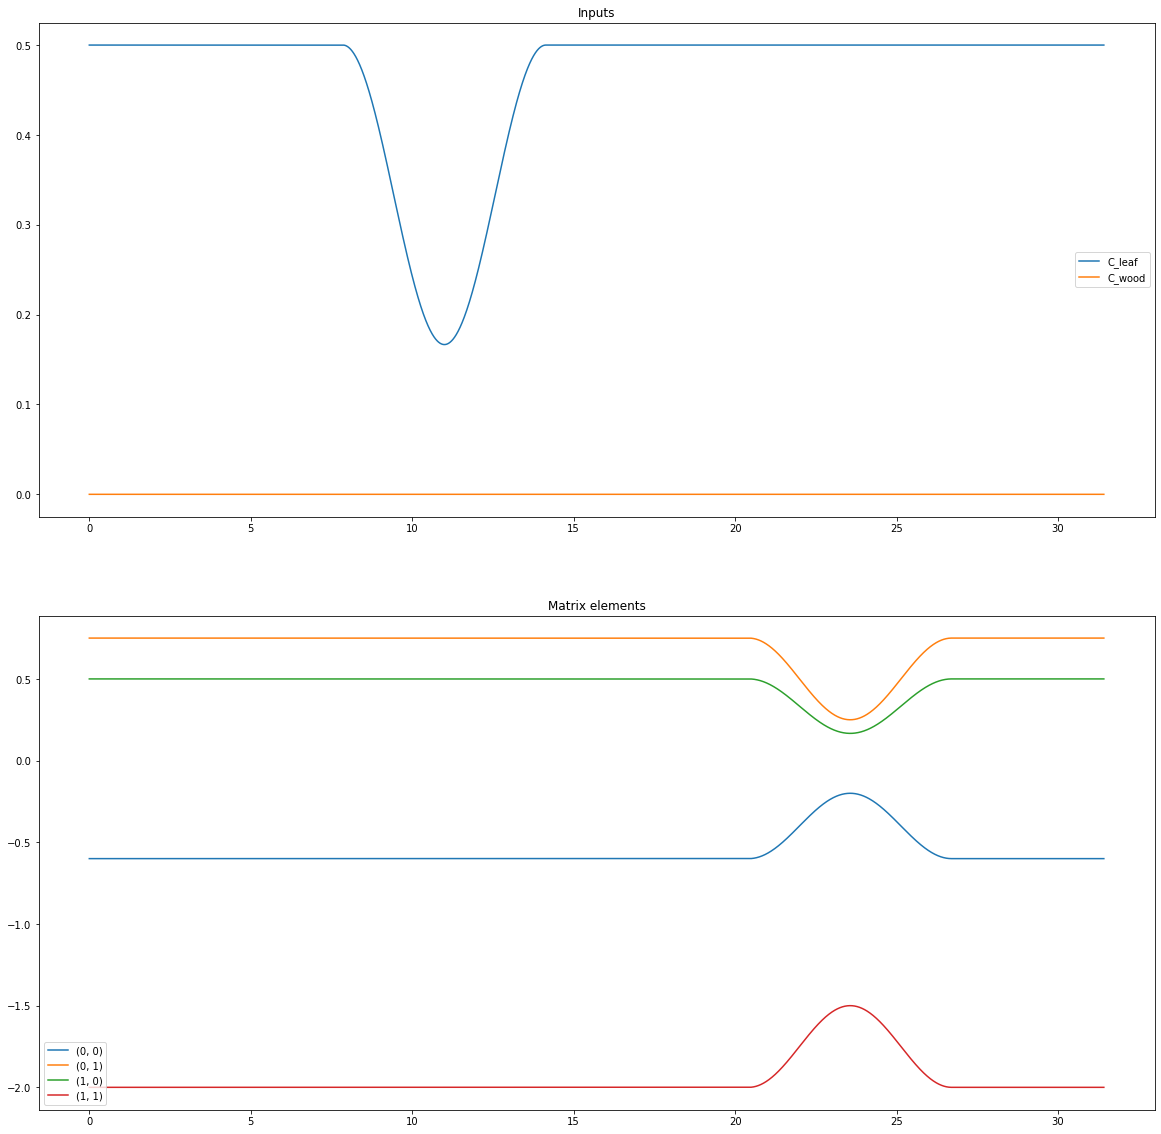

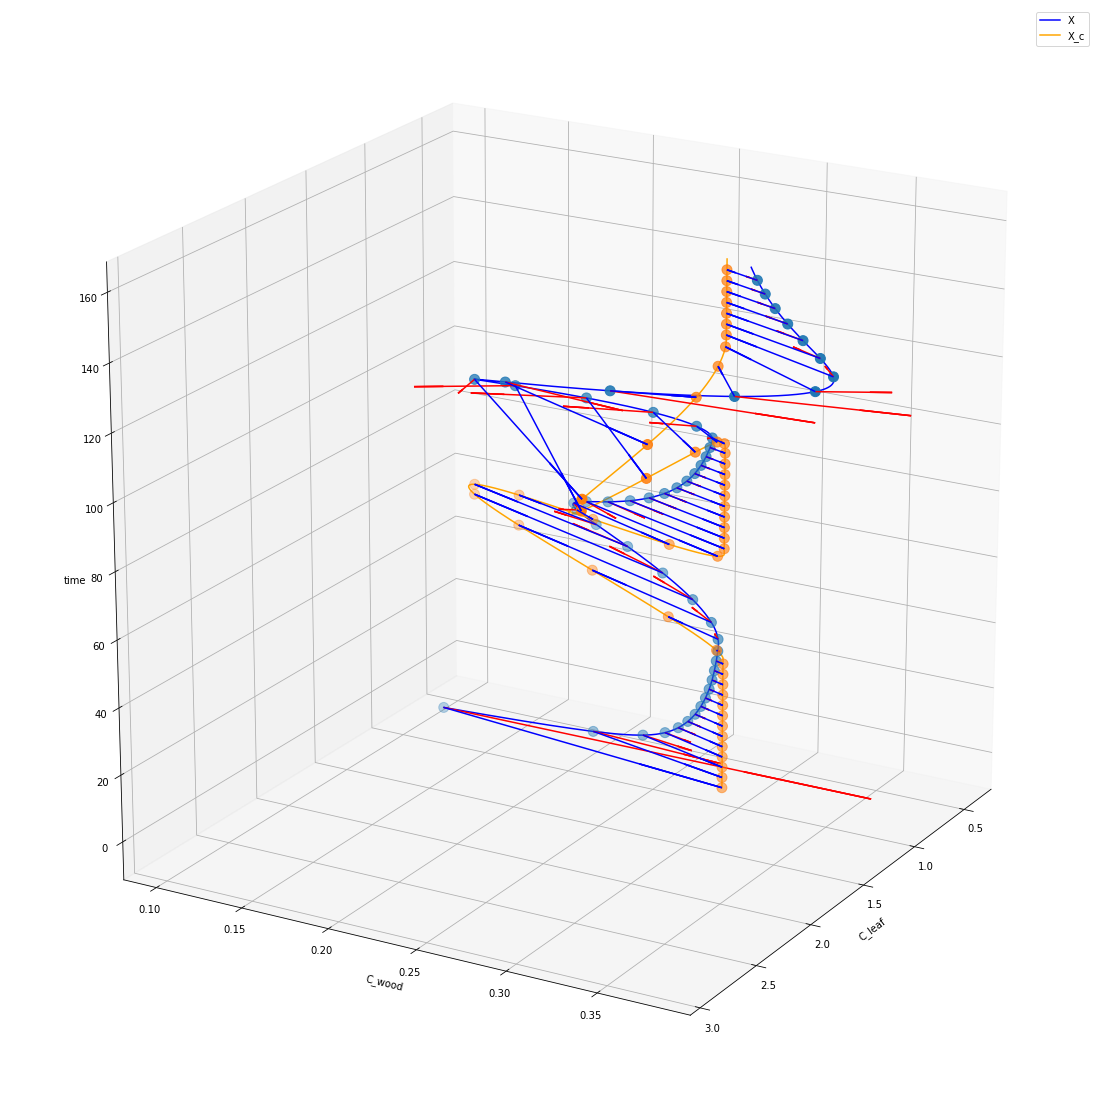

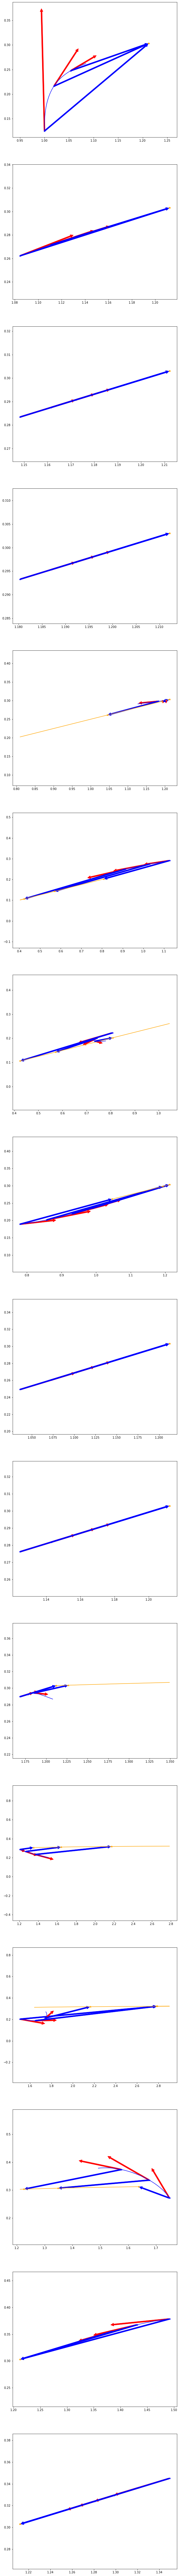

In [92]:
# define the system symbolically 

# all the symbols you are going to use in the equations
var("""
    C_leaf 
    C_wood
    r_leaf2wood_0
    r_wood2leaf
    r_leaf2out
    r_wood2out
    I_leaf_0
""")
t=TimeSymbol("t") # the symbol used for time since it has a special role

# now we create intervals of different behaviour
# by defining the functions piecewitart with a frozen system (I(t)=I_0=const. B(t)=B_0=const.)
calm=2*pi
crazy=calm
delta=pi
#we let the input loose first 
t_thaw_I_0=calm+1/2*pi
#we let the input loose first 
t_freeze_I_0=t_thaw_I_0+crazy
#t_thaw_I_1=t_freeze_I_0+calm
#t_freeze_I_1=t_thaw_I_1+crazy

t_thaw_xi_0=t_freeze_I_0+calm
t_freeze_xi_0=t_thaw_xi_0+crazy
#r_leaf2wood=r_leaf2wood*Piecewise((1,True))
os=2 # >1 (otherwise negative influx)
I_leaf=Piecewise(
    (I_leaf_0,t<t_thaw_I_0),
    ((sin(t)+os)/(os+1)*I_leaf_0,t<t_freeze_I_0),
    #(I_leaf_0,t<t_thaw_I_1),
    #((sin(t)+os)/(os+1)*I_leaf_0,t<t_freeze_I_1),
    (I_leaf_0,True)
)
xi= Piecewise(
    (1,t<t_thaw_xi_0),
    ((sin(t)+os)/(os+1),t<t_freeze_xi_0),
    #((sin(t-delta)+os)*r_leaf2wood_0,t<t_freeze_xi_0),
    (1,True)
)
#I_leaf=20*Piecewise((1,True))
# formulate the model
mvs = CMTVS(
    {
        StateVariableTuple( # the pool names in your preferred order
            (
                C_leaf,
                C_wood
            )
        ), 
        t, 
        InFluxesBySymbol({
            C_leaf: I_leaf,
            C_wood: 0
        }),
        OutFluxesBySymbol({
            C_leaf: xi*r_leaf2out * C_leaf,
            C_wood: r_wood2out * C_wood 
        }),
        InternalFluxesBySymbol({
            (C_leaf, C_wood): xi*r_leaf2wood_0 *C_leaf, 
            (C_wood, C_leaf): xi*r_wood2leaf *C_wood
        }),
    },
    bgc_md2_computers()

)

#start to query the model description..
M=mvs.get_CompartmentalMatrix()
M
#M.inverse_LU()
display(mass_balance_equation(mvs))

param_dict={
    r_leaf2wood_0: 0.5,
    r_wood2leaf: 0.75,
    r_leaf2out: 0.1,
    r_wood2out: 1.25,
    I_leaf_0: 0.5,
}
func_dict={}

t_start=0
#t_end=15*np.pi
t_end=5*float(calm.subs({pi: np.pi}))

X_0=np.array([1,.125])#.reshape((2,1))

t_eval=np.linspace(
    start=t_start,
    stop=t_end,
    #num=1000
    num=5000
)

plot_vectors(mvs,param_dict,X_0,t_eval)

### The graph shows the temporal development of a two pool system.
(The red arrows show the derivative $\dot{\mathbf{X}}$ the blue ones $\mathbf{X}_p$)
- At first the system is autonomous but out of equilibrium.
  In this situation the solution *does* move towards its stable equilibrium which in this situation is identical to $\mathbf{X_c}=\mathbf{B}^{-1} \mathbf{I_0}$;
- In the second time interval the input to the first pool is genuine functions of time. During this time the derivative (red arrow) is **not** parallel ( "proportional") to $\mathbf{X_p}$, as claimed in the paragraph 3.2.
  At some points the vectors are even perpendicular.
- As soon as we freeze the input and the matrix at time creating for some time an autonomuous system we see chasing and near conversion of $\mathbf{X}$ towards $\mathbf{X_c}$. This illustrates tat $\mathbf{X_c}(t_0)$ is the steady state prediction for the frozen system ($\mathbf{I}$  and $M$ fixed at $\mathbf{I}(t_0)$ and $M(t_0)$.     

- If we start shaking $\mathbf{I}$ or $M(t)$ again,  $\mathbf{X}$  will stop  persuing $\mathbf{X_c}$ again (or at least not persue it by running towards it but sometimes away ;-)) 

In [93]:
from sympy import Matrix,Function,Symbol,diff, Rational 
from sympy.printing import latex
from IPython.display import Latex,Math
x_1,x_2=map(Symbol,("x_1","x_2"))
#M=Matrix([[1,-1/2],[-1/2,1/2]])
M=Matrix([[5,0],[-Rational(9,2),1]])
I=Matrix([1,0])
M

Matrix([
[   5, 0],
[-9/2, 1]])

In [94]:
sv=Matrix([x_1,x_2])

X_c=M.inverse_LU()*I

## show the sign flip  in one of the components
X_0=Matrix([1,1])
X_p_0=X_c-X_0
X_dot_0=I-M*X_0
X_c

display(X_c, X_dot_0,X_p_0, sum(X_dot_0), sum(X_p_0))

eq =  r'\frac{d}{dt}'+ rf'{latex(sv)}'+ "="+ rf'{latex(I)}'+ r'+'+ rf'{latex(-M)}'+ rf'{latex(sv)}'
print(eq)
print("##############")

text = rf"""
$\tau={latex(M.inverse_LU())}$,
$\X_c={latex(X_c)}$,
$\X_0={latex(X_0)}$,
$\X_p={latex(X_p_0)}$,
$\X^\prime={latex(X_dot_0)}$
"""
print(text)

Matrix([
[ 1/5],
[9/10]])

Matrix([
[ -4],
[7/2]])

Matrix([
[ -4/5],
[-1/10]])

-1/2

-9/10

\frac{d}{dt}\left[\begin{matrix}x_{1}\\x_{2}\end{matrix}\right]=\left[\begin{matrix}1\\0\end{matrix}\right]+\left[\begin{matrix}-5 & 0\\\frac{9}{2} & -1\end{matrix}\right]\left[\begin{matrix}x_{1}\\x_{2}\end{matrix}\right]
##############

$\tau=\left[\begin{matrix}\frac{1}{5} & 0\\\frac{9}{10} & 1\end{matrix}\right]$,
$\X_c=\left[\begin{matrix}\frac{1}{5}\\\frac{9}{10}\end{matrix}\right]$,
$\X_0=\left[\begin{matrix}1\\1\end{matrix}\right]$,
$\X_p=\left[\begin{matrix}- \frac{4}{5}\\- \frac{1}{10}\end{matrix}\right]$,
$\X^\prime=\left[\begin{matrix}-4\\\frac{7}{2}\end{matrix}\right]$



In [95]:
## now show the sign flip in the sum (just for Yiqi)

I=Matrix([1,1])
X_c=M.inverse_LU()*I
X_0=Matrix([Rational(1,3),Rational(9,5)])
X_p_0=X_c-X_0
X_dot_0=I-M*X_0
display(X_c, X_dot_0,X_p_0, sum(X_dot_0), sum(X_p_0))
text = rf"""
$I={latex(I)}$,
$\X_c={latex(X_c)}$,
$\X_0={latex(X_0)}$,
$\X_p={latex(X_p_0)}$,
$\X^\prime={latex(X_dot_0)}$
"""
print(text)

eq =  r'\operatorname{sign}(\sum_i \mathbf{X_p})= \operatorname{sign}('+\
rf'{latex(sum(X_p_0))})'+\
r' \ne \operatorname{sign}('+rf'{latex(sum(X_dot_0))})='+\
r'\operatorname{sign}(\sum_i (\mathbf{X}^{\prime})_i)'
print(eq)

Matrix([
[  1/5],
[19/10]])

Matrix([
[-2/3],
[7/10]])

Matrix([
[-2/15],
[ 1/10]])

1/30

-1/30


$I=\left[\begin{matrix}1\\1\end{matrix}\right]$,
$\X_c=\left[\begin{matrix}\frac{1}{5}\\\frac{19}{10}\end{matrix}\right]$,
$\X_0=\left[\begin{matrix}\frac{1}{3}\\\frac{9}{5}\end{matrix}\right]$,
$\X_p=\left[\begin{matrix}- \frac{2}{15}\\\frac{1}{10}\end{matrix}\right]$,
$\X^\prime=\left[\begin{matrix}- \frac{2}{3}\\\frac{7}{10}\end{matrix}\right]$

\operatorname{sign}(\sum_i \mathbf{X_p})= \operatorname{sign}(- \frac{1}{30}) \ne \operatorname{sign}(\frac{1}{30})=\operatorname{sign}(\sum_i (\mathbf{X}^{\prime})_i)
